In [1]:
from robust_analysis import train_ridge_regression, train_robust_model, compute_weights,\
                            leave_one_out, leave_one_out_procedure, cross_validation_loo

import pickle
import os 
import netCDF4 as netcdf
import skimage
import numpy as np
import torch 

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))


# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))


# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}


for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
        else:
            mean_ref_ensemble += np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=0)/ len(dic_processed_ssp585[m])
    
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = dic_processed_ssp585[m][i] - mean_ref_ensemble


# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()
    mean_spatial_ensemble = 0
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):     
        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
        else:
            mean_spatial_ensemble += np.nanmean(dic_forced_response_ssp585[m][i],axis=(1, 2))/ len(dic_forced_response_ssp585[m])
            
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.mean(mean_spatial_ensemble[131:164])
    


time_period = 33
grid_lat_size = 36
grid_lon_size = 72

y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        y_forced_response[m][i] = dic_forced_response_ssp585[m][i][131:164]
        x_predictor[m][i] = dic_processed_ssp585[m][i][131:164,:,:]

        nans_idx = np.where(np.isnan(x_predictor[m][i].ravel()))[0]


# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    arr_tmp = np.zeros((len(dic_processed_ssp585[m].keys()),33))
    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        arr_tmp[idx_i,:] = np.nanmean(dic_processed_ssp585[m][i][131:164,:,:],axis=(1,2))
    variance_processed_ssp585[m] = np.mean(np.var(arr_tmp,axis=0))
    std_processed_ssp585[m] = np.mean(np.std(arr_tmp,axis=0))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


In [2]:
# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = {}
    y_train[m] = {}
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        x_train[m][i] = torch.from_numpy(np.nan_to_num(x_predictor[m][i]).reshape(x_predictor[m][i].shape[0],x_predictor[m][i].shape[1]*x_predictor[m][i].shape[2])).to(torch.float64)
        y_train[m][i] = torch.from_numpy(np.nan_to_num(y_forced_response[m][i])).to(torch.float64)
    
        nans_idx = np.where(np.isnan(x_predictor[m][i][0,:,:].ravel()))[0]

# Start the swap

In [3]:
import random

def build_subset_runs(m,n,x,y):
    """
    Return an array containing randomly a given number of runs.
    """
    assert n <= len(x[m].keys());

    # draw = np.random.randint(0,len(x[m].keys()), size=n)
    draw = random.sample(range(len(x[m].keys())), n)
    lst_run_names = list(x[m].keys())
    lst_subset_runs = []

    for idx,i in enumerate(draw):
        lst_subset_runs.append(lst_run_names[i])
    return lst_subset_runs

In [4]:
# build a model with 80 - 20 % runs of two different models and check on a given run, what it gives us
def swap_runs(m1,m2,n,x,y):
    """
    Take n1 runs of model m1 and n2 runs of model m2, and learn a robust model towards run. How to test this?
    """
    assert n<=len(list(x[m1].keys()));
    assert n<=len(list(x[m2].keys()));

    lst1 = build_subset_runs(m1,n,x,y)
    lst2 = build_subset_runs(m2,n,x,y)

    # swap runs: create a new dictionary and do the swap 
    x_tmp = x.copy()
    y_tmp = y.copy()
    
    for idx_r, r in enumerate(lst1):

        x_tmp[m1][r] = x[m2][lst2[idx_r]]
        y_tmp[m1][r] = y[m2][lst2[idx_r]]
            
        x_tmp[m2][lst2[idx_r]] = x[m1][r]
        y_tmp[m2][lst2[idx_r]] = y[m1][r]

    return x_tmp, y_tmp


def add_runs(m1,m2,n1,x,y):
    """
    Take n1 runs of model m1 and add them in model m2.
    """
    assert n1 <= len(list(x[m1].keys()));
    
    # create the list of n1 runs 
    lst1 = build_subset_runs(m1,n1,x,y)
    
    # add runs: create a new dictionary and do the swap 
    x_tmp = x.copy()
    y_tmp = y.copy()
    
    for idx_r, r in enumerate(lst1):

        x_tmp[m2][m2+'_'+r] = x[m1][r]
        y_tmp[m2][m2+'_'+r] = y[m1][r]
            
    
    return x_tmp, y_tmp

def remove_runs(m1,n1,x,y):
    """
    Take n1 runs of model m1 and add them in model m2.
    """
    assert n1 <= len(list(x[m1].keys()));

    # add runs: create a new dictionary and do the swap 
    x_tmp = x.copy()
    y_tmp = y.copy()
    
    for idx_r, r in enumerate(lst1):

        x_tmp[m1].pop(r)
        y_tmp[m1].pop(r)
            
    
    return x_tmp, y_tmp


def mix_runs(m1,m2,n1,n2,x,y):
    """
    Create a model that mixes runs from model m1 and model m2.
    """
    assert n1<=len(list(x[m1].keys()));
    assert n2<=len(list(x[m2].keys()));

    # mix runs: create a new dictionary and do the swap 
    x_tmp = x.copy()
    y_tmp = y.copy()

    x_tmp[m1+'_'+m2] = {}
    y_tmp[m1+'_'+m2] = {}
    
    for idx_r, r in enumerate(lst1):

        x_tmp[m1+'_'+m2][m1+'_'+r] = x[m1][r]
        y_tmp[m1+'_'+m2][m1+'_'+r] = y[m1][r]

    for idx_r, r in enumerate(lst2):
            
        x_tmp[m1+'_'+m2][m2+'_'+r] = x[m2][r]
        y_tmp[m1+'_'+m2][m2+'_'+r] = x[m2][r]

    return x_tmp, y_tmp

In [5]:
def concat_runs(x,y,lon_size,lat_size):
    """
    Concatenate runs.
    """
    # Data preprocessing
    x_train = {}
    y_train = {}
    
    for idx_m,m in enumerate(x.keys()):
        x_train[m] = 0
        y_train[m] = 0
        
        for idx_i, i in enumerate(x[m].keys()):
            
            if idx_i ==0:
                y_train[m] = y[m][i]
                x_train[m] = x[m][i]
            else:
                # print(y[m][i].shape)
                # print(y_train[m].shape)
                y_train[m] = np.concatenate([y_train[m],y[m][i]])
                x_train[m] = np.concatenate([x_train[m],x[m][i]],axis=0)  
                y_train[m] = np.concatenate([y_train[m],y[m][i]])
                x_train[m] = np.concatenate([x_train[m], x[m][i]],axis=0)  
        x_train[m] = torch.from_numpy(x_train[m])
        y_train[m] = torch.from_numpy(y_train[m])
    return x_train, y_train

# Plan of the notebook

In [6]:
## First approach: take two climate models, swap the runs, train on the swaped runs and test on another one.
# Compare it with the approach when we just train on two climate models.
## Second approach: take two climate models, swap the runs, train the model by assigning individual weights on the runs and test on another one.
#( need to write the math)

#  First approach here

In [7]:
# take the first three models
lst_models = list(dic_reduced_ssp585.keys())
subset_models = lst_models[:3]

In [8]:
# build a model where we train on runs from different climate models
def train_robust_model(x,y,vars,lon_size,lat_size,models,alpha_=1.0,lambda_=1.0,nbEpochs=100,verbose=True):
    """
    Learn parameter β such that β = argmin( log Σ_m exp(||y_m - X_m^T β||^2) ).

    Args:
        - x,y : location, observation 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - models: (sub)list of models (list)
        - alpha_: softmax coefficient (float)
        - nbepochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    beta = torch.zeros(lon_size*lat_size).to(torch.float64)
    beta.requires_grad_(True)  
                          
    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-3)
            
    # --- optimization loop ---                
    for epoch in torch.arange(nbEpochs):      
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
                    
        # first term: ||Y - X - Rb ||
        res = torch.zeros(len(models))
        for idx_m,m in enumerate(models):
            res[idx_m] = (1/alpha_)*torch.mean((y[m] - torch.matmul(x[m],beta))**2)/vars[m]
    
        obj = alpha_*torch.logsumexp(res,0)
        obj = torch.tensor(0.0)
        for m in models:
            obj += torch.exp((1/alpha_)*torch.mean((y[m] - torch.matmul(x[m],beta))**2)/vars[m])
    
        obj = alpha_*torch.log(obj)

        obj += lambda_*torch.norm(beta,p=2)**2
                    
        #define loss function
        loss = obj
                    
        # Use autograd to compute the backward pass. 
        loss.backward(retain_graph=True)               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()       
        
        if(verbose==True):
            if(epoch % 10 == 0):
                print('Epoch ', epoch.detach().item(), 
                    ', loss=', loss.detach().item()
                    )
    return beta.detach().clone()

In [9]:
def train_robust_run(x,y,vars,lon_size,lat_size,alpha_=1.0,lambda_=1.0,nbEpochs=100,verbose=True):
    """
    Learn parameter β such that β = argmin( log Σ_r exp(||y_r - X_r^T β||^2) ).

    Args:
        - x,y : location, observation 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - alpha_: softmax coefficient (float)
        - nbEpochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    beta = torch.zeros(lon_size*lat_size).to(torch.float64)
    beta.requires_grad_(True)  
                          
    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-3)
            
    # --- optimization loop ---                
    for epoch in torch.arange(nbEpochs):      
                      
        optimizer.zero_grad()
        ############### Define loss function ##############

        ######### Test #####################
        res = torch.zeros(len(runs))
        for idx_r, r in enumerate(runs):
            res[idx_r] = (1/alpha_)*torch.mean((y[r] - torch.matmul(x[r],beta))**2)
        
        obj = alpha_*torch.logsumexp(res,0)
        ####################################

        obj += lambda_*torch.norm(beta,p=2)**2
                                
        #define loss function
        loss = obj

        ######### optimize #################
        # Use autograd to compute the backward pass. 
        loss.backward(retain_graph=True)               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()       
        
        if(verbose==True):
            if(epoch % 10 == 0):
                print('Epoch ', epoch.detach().item(), 
                    ', loss=', loss.detach().item()
                    )
    return beta.detach().clone()

In [10]:
n=3
x_tmp,y_tmp = swap_runs(subset_models[0],subset_models[1],n,x_train,y_train)
x_tmp,y_tmp = concat_runs(x_tmp,y_tmp,grid_lon_size,grid_lat_size) 

beta = train_robust_model(x_tmp,y_tmp,variance_processed_ssp585,\
                           grid_lon_size,grid_lat_size,\
                           subset_models[:2],\
                           alpha_=1.0,lambda_=1.0,\
                           nbEpochs=300,verbose=True)

Epoch  0 , loss= 9.64504337310791
Epoch  10 , loss= 3.3064422607421875
Epoch  20 , loss= 1.6941509246826172
Epoch  30 , loss= 1.1802637577056885
Epoch  40 , loss= 0.9839932918548584
Epoch  50 , loss= 0.9183744788169861
Epoch  60 , loss= 0.8854451179504395
Epoch  70 , loss= 0.8620218634605408
Epoch  80 , loss= 0.8478686213493347
Epoch  90 , loss= 0.8387579917907715
Epoch  100 , loss= 0.8301941752433777
Epoch  110 , loss= 0.8231167197227478
Epoch  120 , loss= 0.816897451877594
Epoch  130 , loss= 0.8114584684371948
Epoch  140 , loss= 0.8066108822822571
Epoch  150 , loss= 0.8022776246070862
Epoch  160 , loss= 0.7983753085136414
Epoch  170 , loss= 0.7948406338691711
Epoch  180 , loss= 0.7916237711906433
Epoch  190 , loss= 0.7886836528778076
Epoch  200 , loss= 0.7859861254692078
Epoch  210 , loss= 0.783502995967865
Epoch  220 , loss= 0.78121018409729
Epoch  230 , loss= 0.7790874242782593
Epoch  240 , loss= 0.7771177887916565
Epoch  250 , loss= 0.7752862572669983
Epoch  260 , loss= 0.77358007

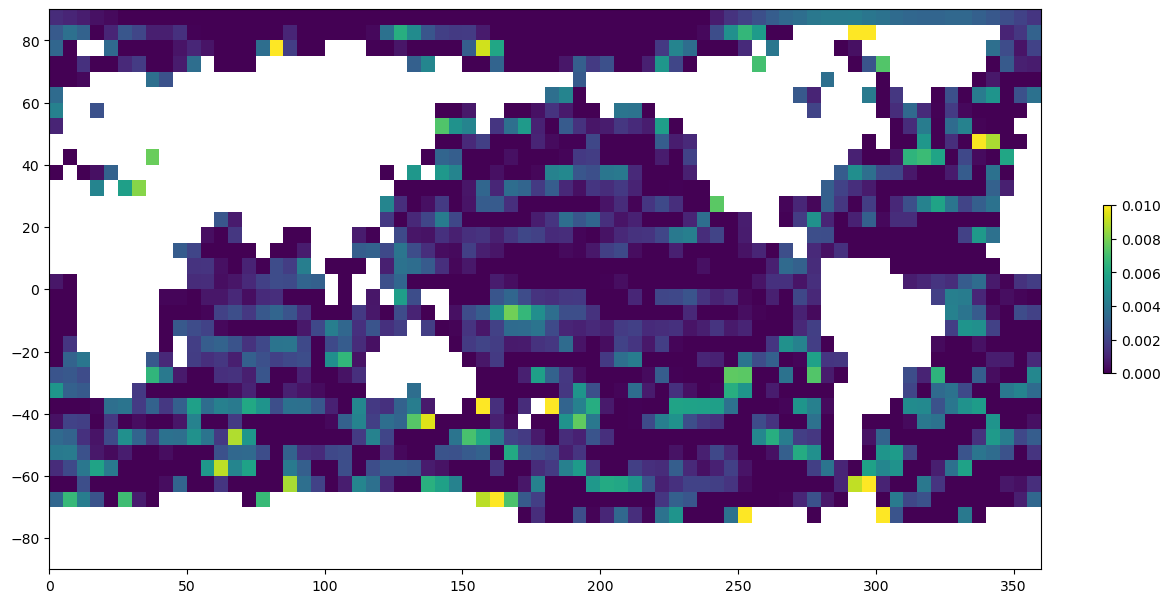

In [11]:
import matplotlib.pyplot as plt

# compute negative part
beta[nans_idx] = float('nan')
beta_tmp = beta.numpy().reshape(grid_lat_size,grid_lon_size)

fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 1, 1)        
im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=0.00,vmax = 0.01)
plt.colorbar(im0, ax=ax0, shrink=0.3)
# ax0.set_xlabel(r'x', size=7)

plt.show()

### Define a subset of models: like 2-3(4) models on which we do the swap, we train the models and test on a given set of models/real data.
### One swap: retrain everything and check the weights. Need to check pairs of similar models. (see if you get the same results)
### Learn run weights
### Add some smoothing in the pattern definition
### Think about a nonlinear approach like VAE to generate patterns given single observation.

In [12]:
# Consider 2 climate models and do the swap

In [13]:
# take the first two models
lst_models = list(dic_reduced_ssp585.keys())
swaped_models = lst_models[:2]


In [14]:
# number of runs to swap
n=5

# build training set with swaped runs
x_tmp_swap,y_tmp_swap = swap_runs(swaped_models[0],swaped_models[1],n,x_train,y_train)
x_tmp_swap,y_tmp_swap = concat_runs(x_tmp_swap,y_tmp_swap,grid_lon_size,grid_lat_size) 

beta_swap = train_robust_model(x_tmp,y_tmp,variance_processed_ssp585,\
                           grid_lon_size,grid_lat_size,\
                           lst_models,\
                           alpha_=1.0,lambda_=1.0,\
                           nbEpochs=200,verbose=True)

# build training set (no swap)

print('===== Train on models =======')
x_tmp,y_tmp = concat_runs(x_train,y_train,grid_lon_size,grid_lat_size) 
beta = train_robust_model(x_tmp,y_tmp,variance_processed_ssp585,\
                           grid_lon_size,grid_lat_size,\
                           lst_models,\
                           alpha_=1.0,lambda_=1.0,\
                           nbEpochs=200,verbose=True)

Epoch  0 , loss= 15.544085502624512
Epoch  10 , loss= 5.928200721740723
Epoch  20 , loss= 3.7786755561828613
Epoch  30 , loss= 4.053781032562256
Epoch  40 , loss= 3.69235897064209
Epoch  50 , loss= 3.702566623687744
Epoch  60 , loss= 3.6712210178375244
Epoch  70 , loss= 3.649012327194214
Epoch  80 , loss= 3.639986038208008
Epoch  90 , loss= 3.6337637901306152
Epoch  100 , loss= 3.6282832622528076
Epoch  110 , loss= 3.623467206954956
Epoch  120 , loss= 3.6191794872283936
Epoch  130 , loss= 3.6153271198272705
Epoch  140 , loss= 3.611825942993164
Epoch  150 , loss= 3.608616352081299
Epoch  160 , loss= 3.6056573390960693
Epoch  170 , loss= 3.602916955947876
Epoch  180 , loss= 3.600367784500122
Epoch  190 , loss= 3.597987174987793
===== Train on models =======
Epoch  0 , loss= 15.541655540466309
Epoch  10 , loss= 5.911311149597168
Epoch  20 , loss= 3.777156114578247
Epoch  30 , loss= 4.053027153015137
Epoch  40 , loss= 3.6895992755889893
Epoch  50 , loss= 3.707458019256592
Epoch  60 , loss=

In [15]:
# evaluate the swap on a given climate model
def plot_beta(beta,lat,lon):
    """
    Display a given beta coefficient. 
    """
    # define grid
    lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')
    lat_size = lat_grid.shape[0]
    lon_size = lon_grid.shape[1]
    
    # compute negative part
    beta_tmp = beta.clone()
    beta_tmp[nans_idx] = float('nan')
    beta_tmp = beta_tmp.numpy().reshape(lat_size,lon_size)
    
    fig0 = plt.figure(figsize=(12,12))           
    
    ax0 = fig0.add_subplot(2, 1, 1)        
    im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=0.00,vmax = 0.01)
    plt.colorbar(im0, ax=ax0, shrink=0.3)
    
    plt.show()

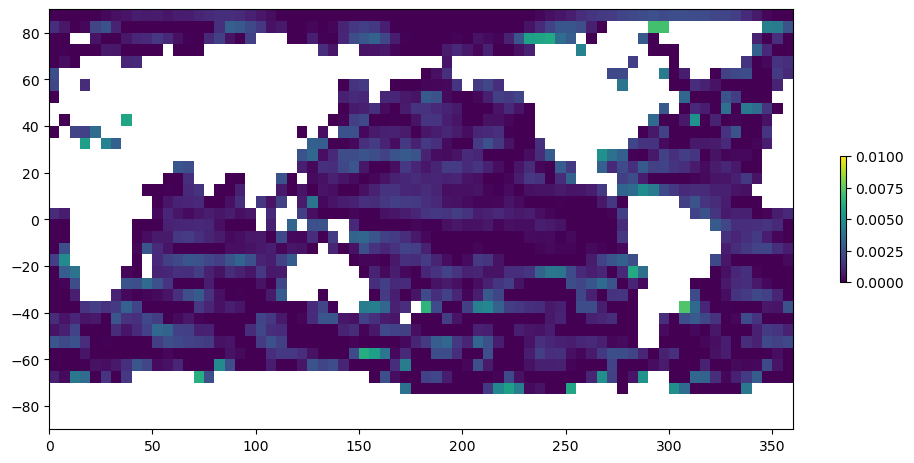

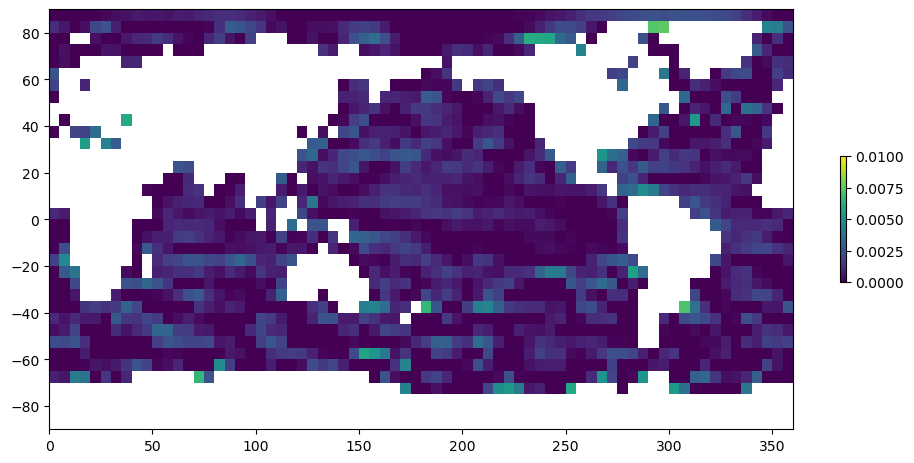

In [16]:
plot_beta(beta_swap,lat,lon)
plot_beta(beta,lat,lon)

In [17]:
# plot the weights to see if it changes something

In [18]:
def plot_weights(beta,x,y,vars,alpha_=1.0):

    # compute the coefficient of the robust model
    M = len(list(x.keys()))
    gamma = torch.zeros(M)
    
    for idx_m,m in enumerate(x.keys()):
        gamma[idx_m] = torch.exp((1/alpha_)*torch.mean((y[m] - torch.matmul(x[m],beta))**2/vars[m]))
    
    gamma = gamma/torch.sum(gamma)
    
    # plot the model contributions
    fig, ax = plt.subplots()
    models = list(x.keys())
    weights = list(gamma.detach().numpy())
    
    ax.bar(models, weights,label='Model weights')
    ax.set_ylabel(r'weights $\gamma$')
    ax.set_title('cmip6 models')
    ax.legend()
    ax.set_xticklabels(models, rotation=-90)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_37115/803046356.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


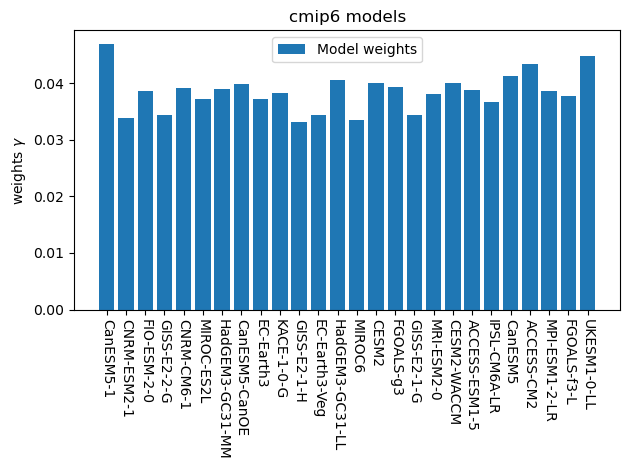

/tmp/ipykernel_37115/803046356.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=-90)


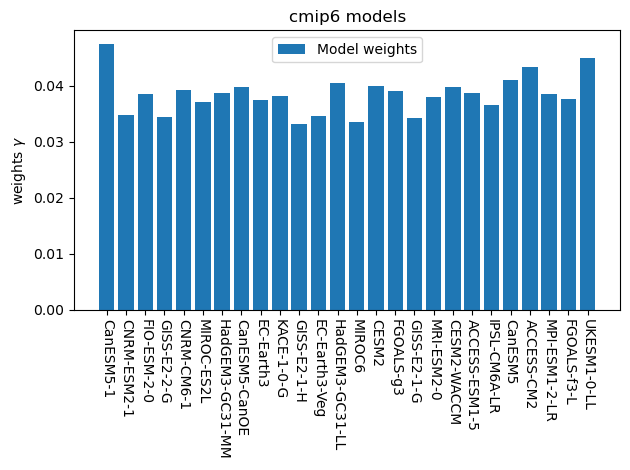

In [19]:
plot_weights(beta,x_tmp,y_tmp,variance_processed_ssp585,alpha_=1.0)
plot_weights(beta_swap,x_tmp_swap,y_tmp_swap,variance_processed_ssp585,alpha_=1.0)

# Train model with robust run weights

In [20]:
def mix_runs(m1,m2,n1,n2,x,y):
    """
    Create a model that mixes runs from model m1 and model m2.
    """
    assert n1<=len(list(x[m1].keys()));
    assert n2<=len(list(x[m2].keys()));

    # create the list of n1 runs 
    lst1 = build_subset_runs(m1,n1,x,y)
    lst2 = build_subset_runs(m2,n2,x,y)

    # mix runs: create a new dictionary and do the swap 
    x_tmp = x.copy()
    y_tmp = y.copy()

    x_tmp[m1+'_'+m2] = {}
    y_tmp[m1+'_'+m2] = {}
    
    for idx_r, r in enumerate(lst1):

        x_tmp[m1+'_'+m2][m1+'_'+r] = x[m1][r]
        y_tmp[m1+'_'+m2][m1+'_'+r] = y[m1][r]

    for idx_r, r in enumerate(lst2):

        x_tmp[m1+'_'+m2][m2+'_'+r] = x[m2][r]
        y_tmp[m1+'_'+m2][m2+'_'+r] = y[m2][r]

    return x_tmp, y_tmp

In [21]:
#### train with different runs
n0 = 10
n1 = 5

# mix runs 
x_tmp_mix,y_tmp_mix = mix_runs(swaped_models[0],swaped_models[1],n0,n1,x_train,y_train)

In [22]:
def train_robust_run(x,y,runs,lon_size,lat_size,alpha_=1.0,lambda_=1.0,nbEpochs=100,verbose=True):
    """
    Learn parameter β such that β = argmin( log Σ_r exp(||y_r - X_r^T β||^2) ).

    Args:
        - x,y : location, observation 
        - lon_size, lat_size: longitude and latitude grid size (Int)
        - alpha_: softmax coefficient (float)
        - nbEpochs: number of optimization steps (Int)
        - verbose: display logs (bool)
    """

    # define variable beta
    beta = torch.zeros(lon_size*lat_size).to(torch.float64)
    beta.requires_grad_(True)  
                          
    # define optimizer
    optimizer = torch.optim.Adam([beta],lr=1e-3)
            
    # --- optimization loop ---                
    for epoch in torch.arange(nbEpochs):      
                      
        optimizer.zero_grad()
        ############### Define loss function ##############
                    
        # first term: ||Y - X - Rb ||
        obj = torch.tensor(0.0)
        for r in runs:
            obj += torch.exp((1/alpha_)*torch.mean((y[r] - torch.matmul(x[r],beta))**2))
    
        obj = alpha_*torch.log(obj)

        obj += lambda_*torch.norm(beta,p=2)**2
                    
        #define loss function
        loss = obj
                    
        # Use autograd to compute the backward pass. 
        loss.backward(retain_graph=True)               
        
        # take a step into optimal direction of parameters minimizing loss
        optimizer.step()       
        
        if(verbose==True):
            if(epoch % 10 == 0):
                print('Epoch ', epoch.detach().item(), 
                    ', loss=', loss.detach().item()
                    )
    return beta.detach().clone()

In [10]:
runs = list(x_tmp_mix[swaped_models[0]+'_'+swaped_models[1]].keys())

beta_test = train_robust_run(x_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],y_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],\
                             runs,grid_lon_size,grid_lat_size,\
                             alpha_=1.0,lambda_=5.0,\
                             nbEpochs=200,verbose=True)n=3
x_tmp,y_tmp = swap_runs(subset_models[0],subset_models[1],n,x_train,y_train)
x_tmp,y_tmp = concat_runs(x_tmp,y_tmp,grid_lon_size,grid_lat_size) 

beta = train_robust_model(x_tmp,y_tmp,variance_processed_ssp585,\
                           grid_lon_size,grid_lat_size,\
                           subset_models[:2],\
                           alpha_=1.0,lambda_=1.0,\
                           nbEpochs=100,verbose=True)

Epoch  0 , loss= 2.728888750076294
Epoch  10 , loss= 2.7165496349334717
Epoch  20 , loss= 2.7129909992218018
Epoch  30 , loss= 2.7126927375793457
Epoch  40 , loss= 2.712786912918091
Epoch  50 , loss= 2.71250057220459
Epoch  60 , loss= 2.7125279903411865
Epoch  70 , loss= 2.712496042251587
Epoch  80 , loss= 2.7124879360198975
Epoch  90 , loss= 2.7124874591827393
Epoch  100 , loss= 2.712486982345581
Epoch  110 , loss= 2.712486982345581
Epoch  120 , loss= 2.712486982345581
Epoch  130 , loss= 2.712486982345581
Epoch  140 , loss= 2.712486982345581
Epoch  150 , loss= 2.712486982345581
Epoch  160 , loss= 2.71248722076416
Epoch  170 , loss= 2.712486982345581
Epoch  180 , loss= 2.712486982345581
Epoch  190 , loss= 2.71248722076416
Epoch  0 , loss= 10.078004837036133
Epoch  10 , loss= 3.4334399700164795
Epoch  20 , loss= 1.7200909852981567
Epoch  30 , loss= 1.157457709312439
Epoch  40 , loss= 0.9791613221168518
Epoch  50 , loss= 0.9202274084091187
Epoch  60 , loss= 0.8945174813270569
Epoch  70 ,

In [24]:
def plot_run_weights(beta,x,y,alpha_=1.0):

    # compute the coefficient of the robust model
    M = len(list(x.keys()))
    gamma = torch.zeros(M)
    
    for idx_m,m in enumerate(x.keys()):
        gamma[idx_m] = torch.exp((1/alpha_)*torch.mean((y[m] - torch.matmul(x[m],beta))**2))
    
    gamma = gamma/torch.sum(gamma)
    
    # plot the model contributions
    fig, ax = plt.subplots()
    models = list(x.keys())
    weights = list(gamma.detach().numpy())
    
    ax.bar(list(x.keys()), weights,label='Run weights')
    ax.set_ylabel(r'weights $\alpha$')
    ax.set_title('ensemble members')
    ax.set_ylim(0.0,0.1)
    ax.legend()
    ax.set_xticklabels(list(x.keys()), rotation=-90)
    plt.tight_layout()
    plt.savefig("run_weights_model"+".png")
    plt.show()

    return gamma

# Mix runs and train the model

In [25]:
# swaped models
swaped_models = ['GISS-E2-1-H','CanESM5']
alpha_ = 0.01
lambda_ = 1.0
#### train with different runs
n0 = len(x_train[swaped_models[0]].keys())
n1 = len(x_train[swaped_models[1]].keys())

# mix runs 
x_tmp_mix,y_tmp_mix = mix_runs(swaped_models[0],swaped_models[1],n0,n1,x_train,y_train)

In [26]:
# try with different pairs:
n0_range = np.arange(1,n0+1)
n1_range = np.arange(1,n1+1)

In [27]:
n0_grid, n1_grid = np.meshgrid(n0_range, n1_range)

In [28]:
# for idx_i,i in enumerate(n0_range):
#     for idx_j,j in enumerate(n1_range):

#         # print("n0 + n1 = ", n0_range[idx_i]+n1_range[idx_j])
#         print("n0 =", n0_range[idx_i])
#         print("n1 =", n1_range[idx_j])
        
#         # mix runs 
#         x_tmp_mix,y_tmp_mix = mix_runs(swaped_models[0],swaped_models[1],n0_range[idx_i],n1_range[idx_j],x_train,y_train)

#         runs = list(x_tmp_mix[swaped_models[0]+'_'+swaped_models[1]].keys())
    
#         beta_swaped_tmp = train_robust_run(x_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],y_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],\
#                                      runs,grid_lon_size,grid_lat_size,\
#                                      alpha_=1.0,lambda_=1.0,\
#                                      nbEpochs=200,verbose=False)


#         plot_run_weights(beta_swaped_tmp,\
#                          x_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],y_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],\
#                          alpha_=0.01)

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


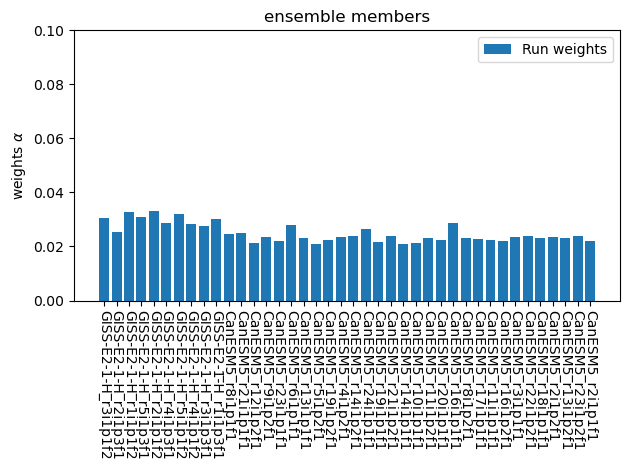

In [29]:
n0_tmp = 10
n1_tmp = 30

# mix runs 
x_tmp_mix,y_tmp_mix = mix_runs(swaped_models[0],swaped_models[1],n0_tmp,n1_tmp,x_train,y_train)

runs = list(x_tmp_mix[swaped_models[0]+'_'+swaped_models[1]].keys())
    
beta_swaped_tmp = train_robust_run(x_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],y_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],\
                                     runs,grid_lon_size,grid_lat_size,\
                                     alpha_=alpha_,lambda_=lambda_,\
                                     nbEpochs=200,verbose=False)


gamma = plot_run_weights(beta_swaped_tmp,\
                x_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],y_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],\
                alpha_=alpha_)

In [30]:
###### Compute residual ##########
sst_tmp = sst[131:164,:,:].reshape((33,lon.shape[0]*lat.shape[0])).copy()
sst_tmp[np.abs(sst_tmp)> 1e20] = float('nan')
ytrue = np.nanmean(sst_tmp,axis=1)

# for each model, compute the predicted values 
sst_tmp_zeros = sst[131:164,:,:].reshape((33,lon.shape[0]*lat.shape[0])).copy()
sst_tmp_zeros[np.abs(sst_tmp_zeros)> 1e20] = 0.0


ypred = np.matmul(beta_swaped_tmp,sst_tmp_zeros.T)

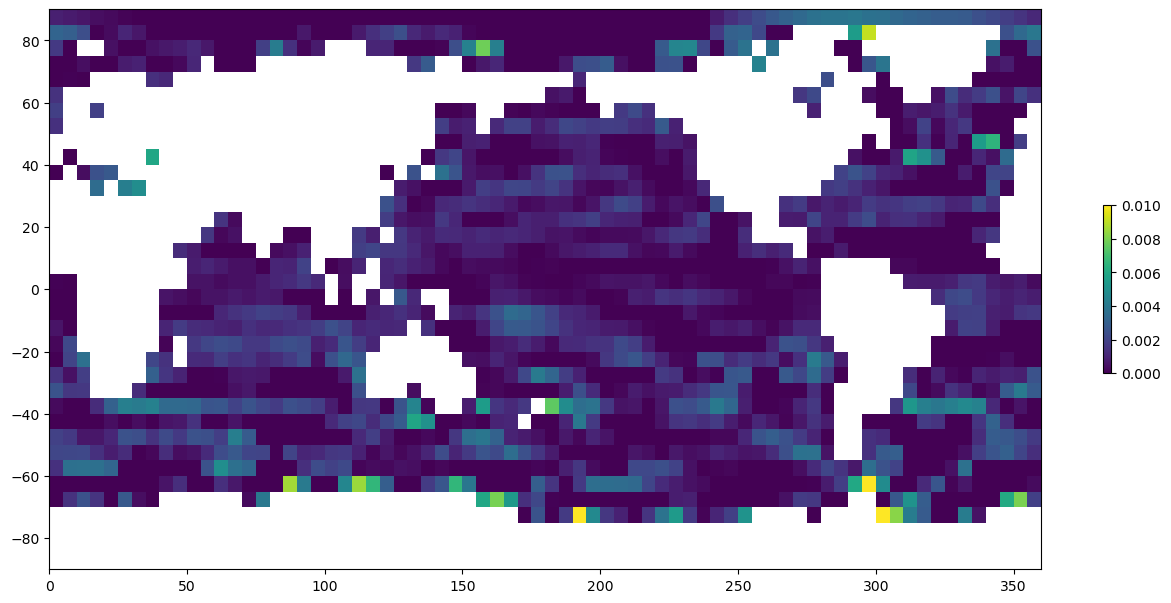

In [12]:
torch.mean((ypred - ytrue)**2)

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


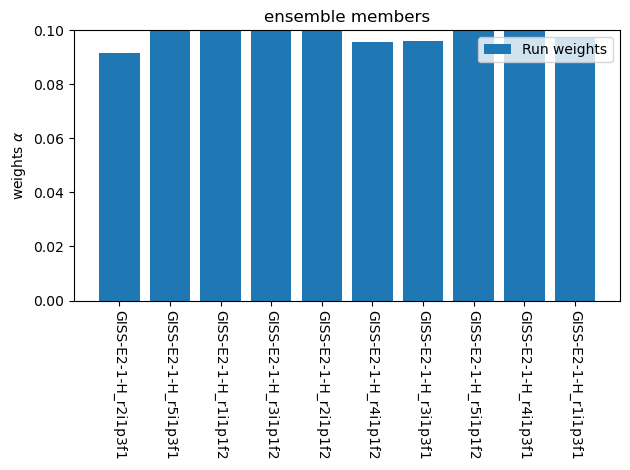

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


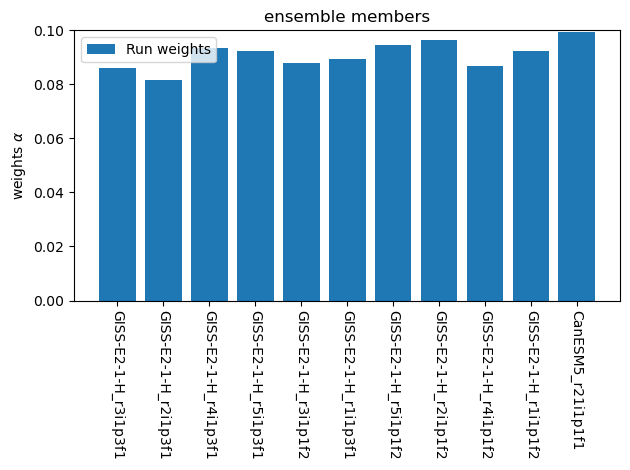

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


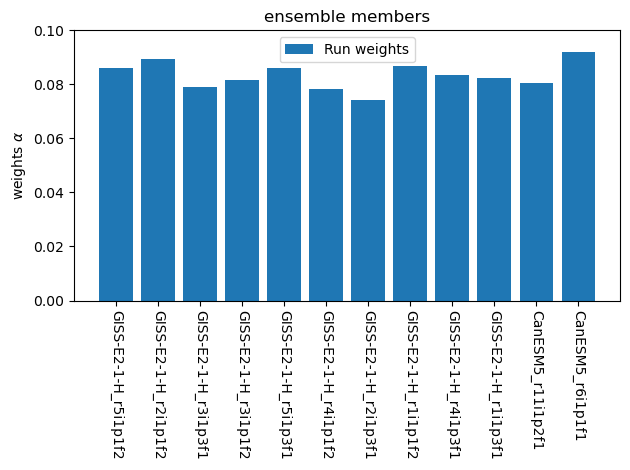

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


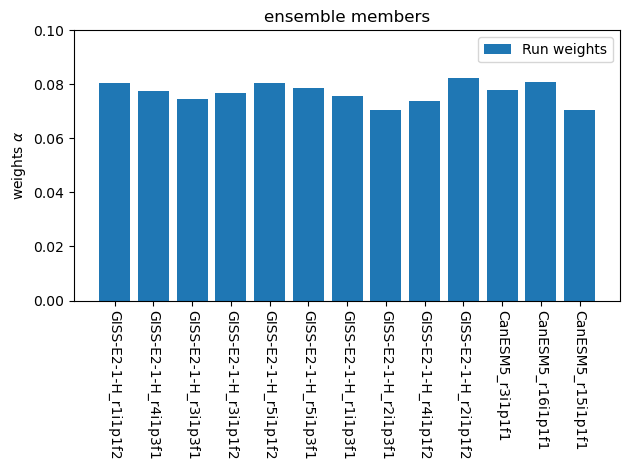

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


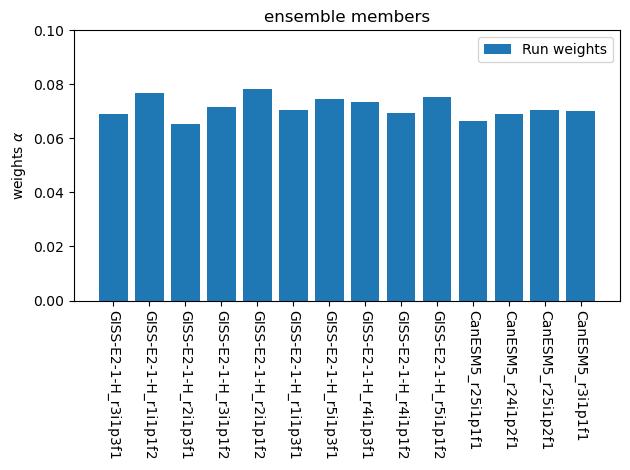

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


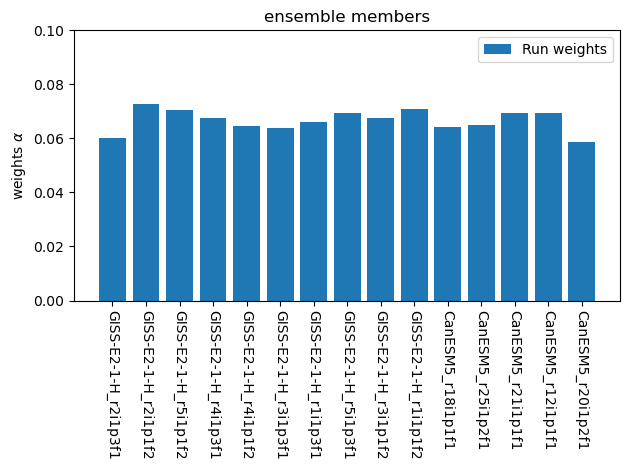

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


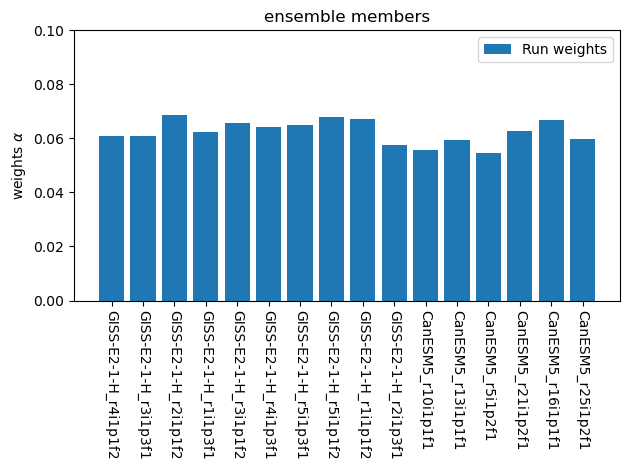

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


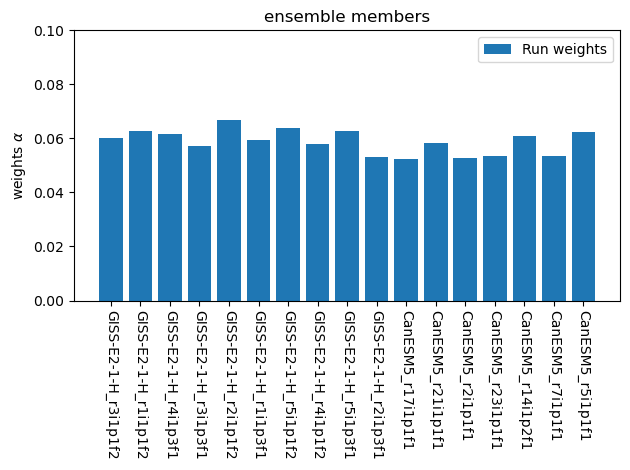

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


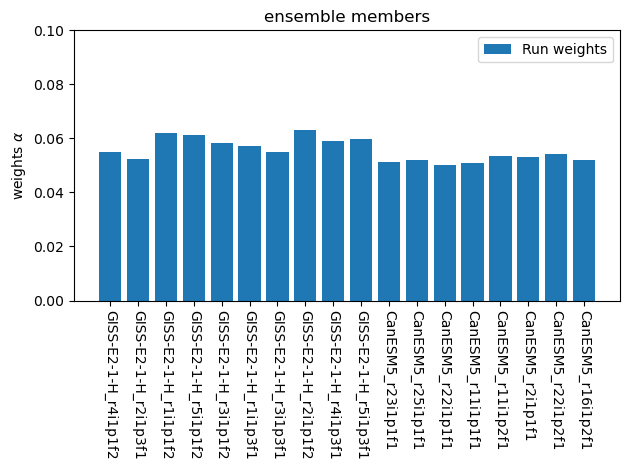

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


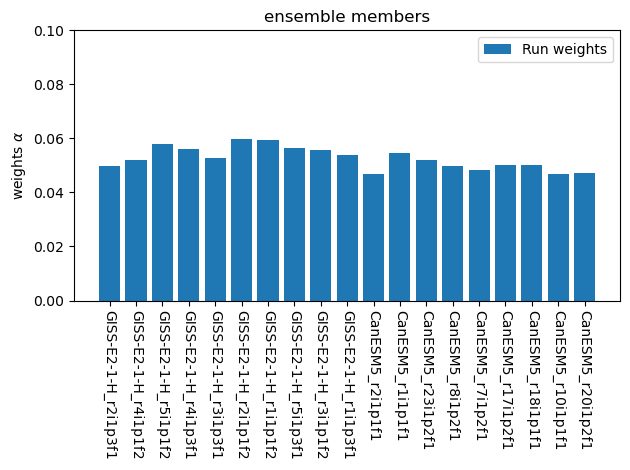

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


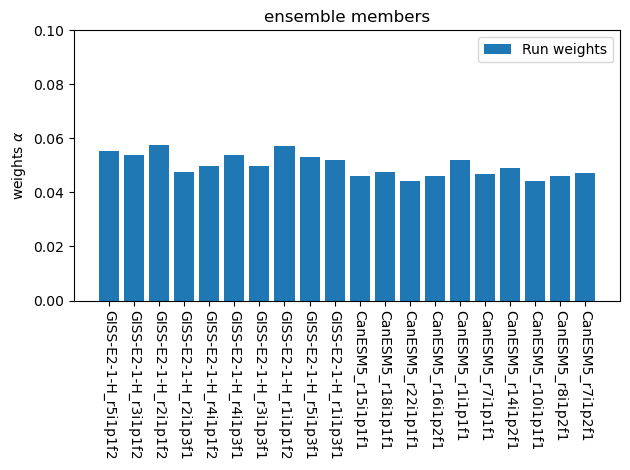

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


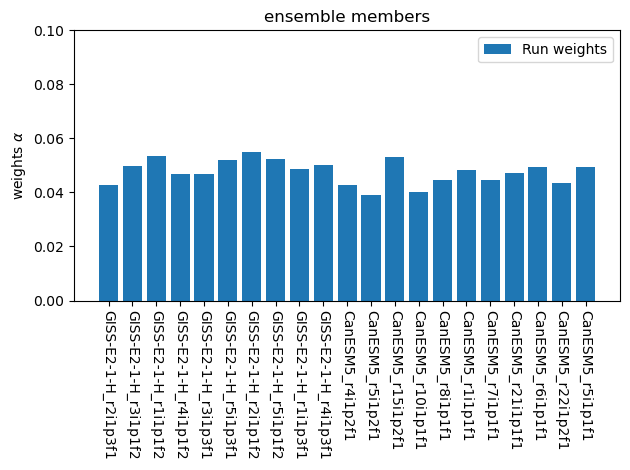

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


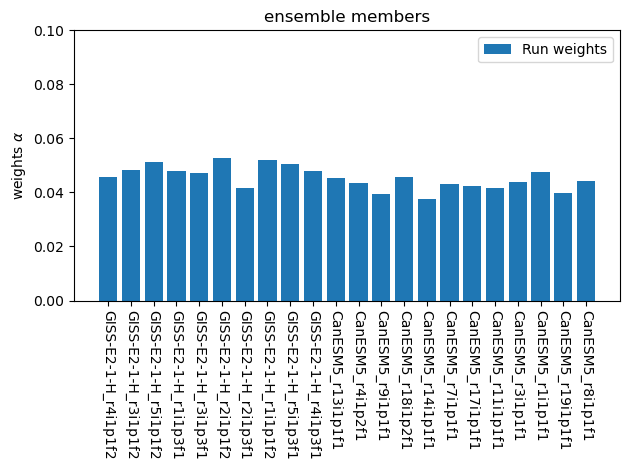

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


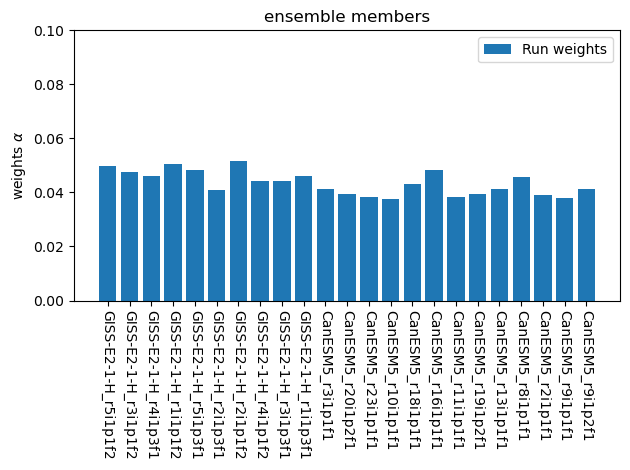

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


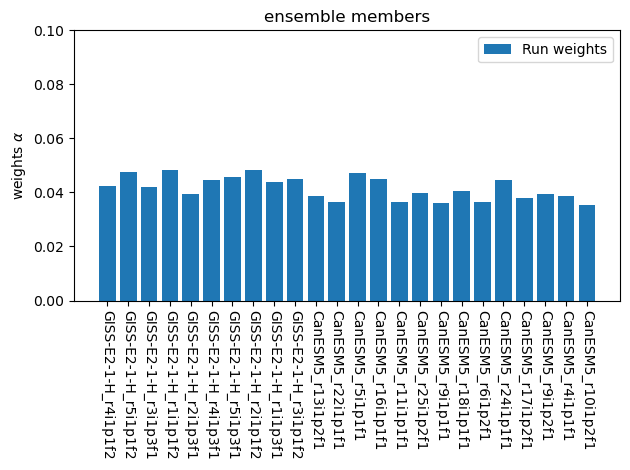

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


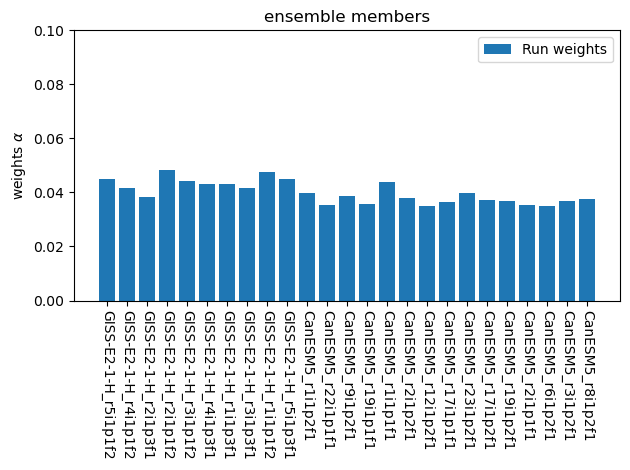

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


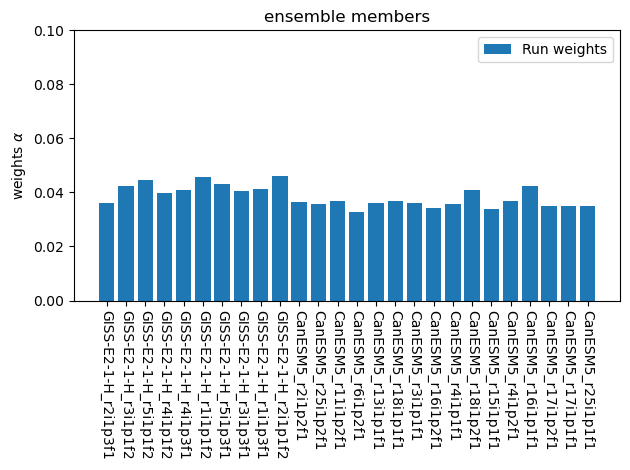

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


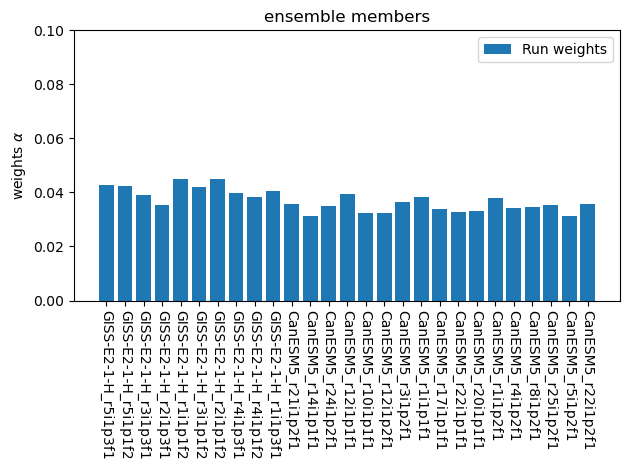

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


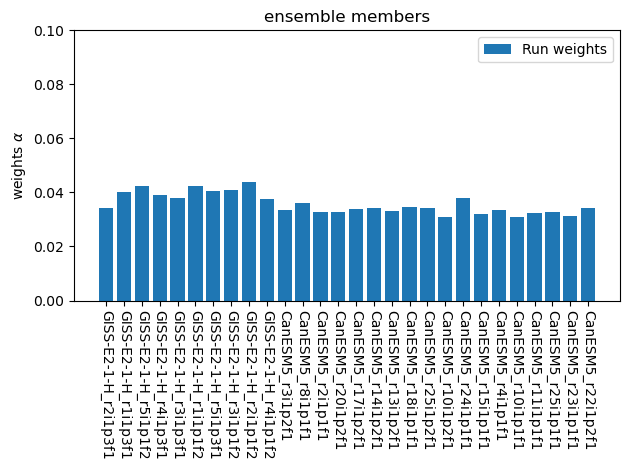

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


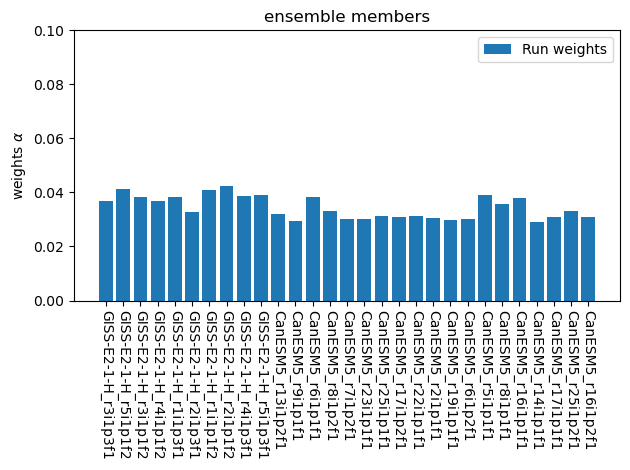

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


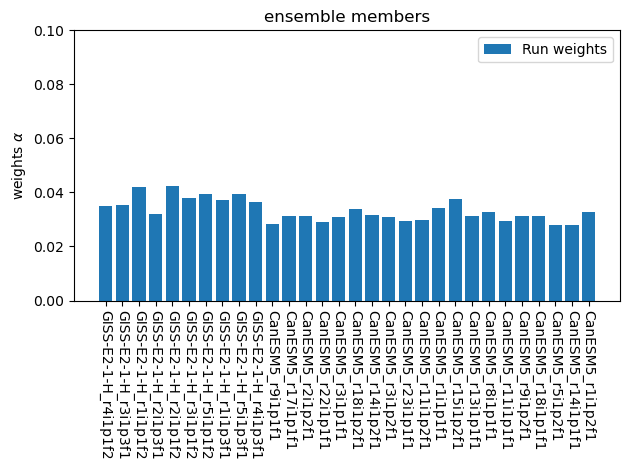

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


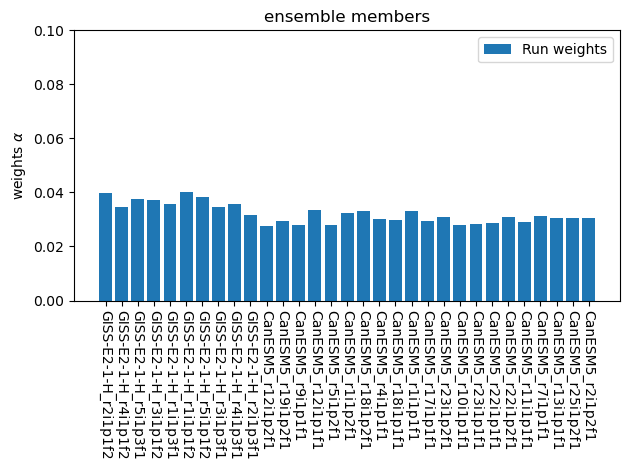

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


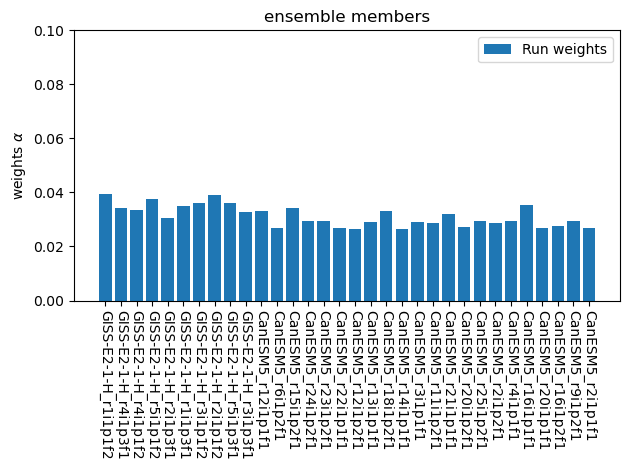

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


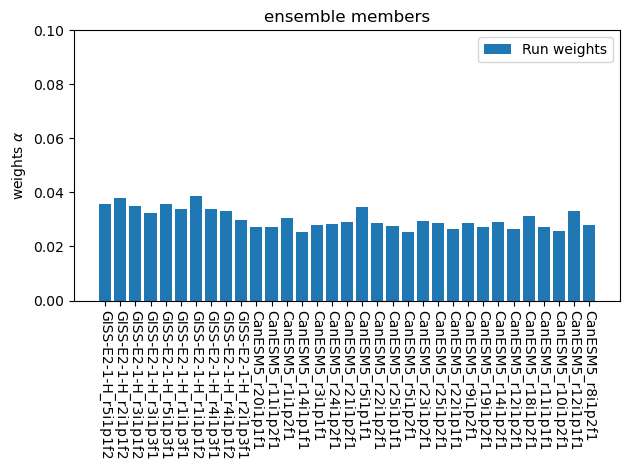

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


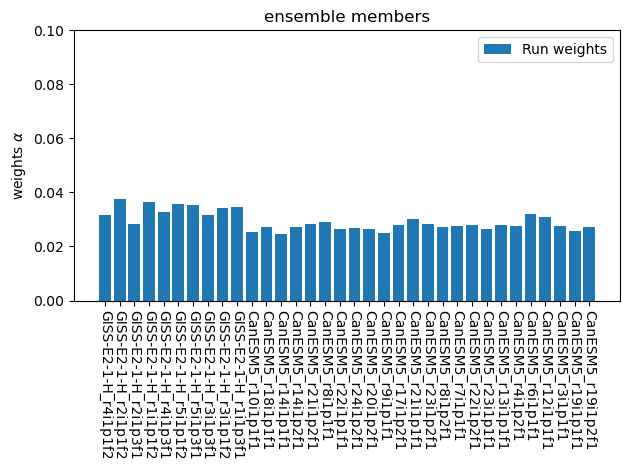

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


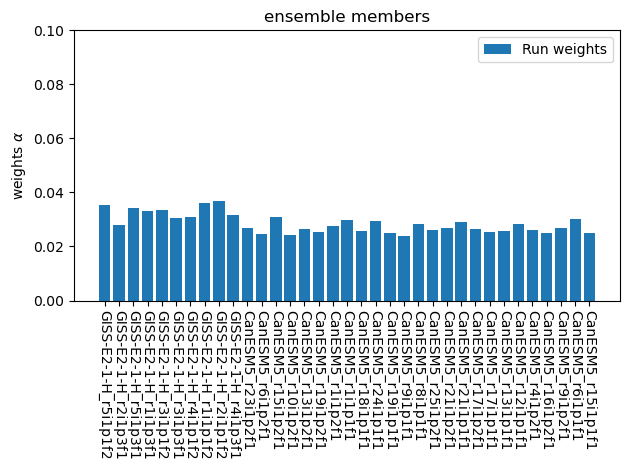

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


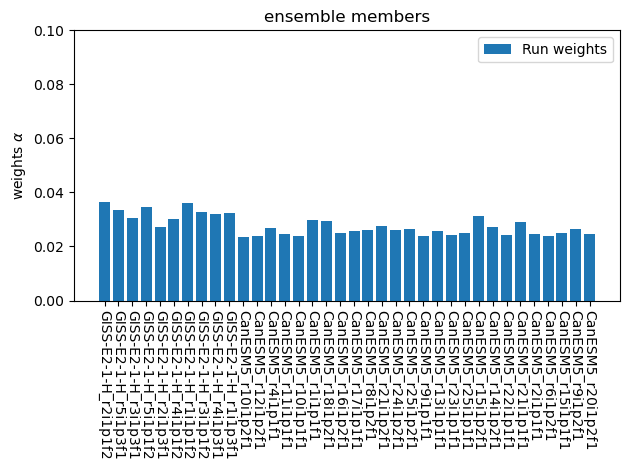

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


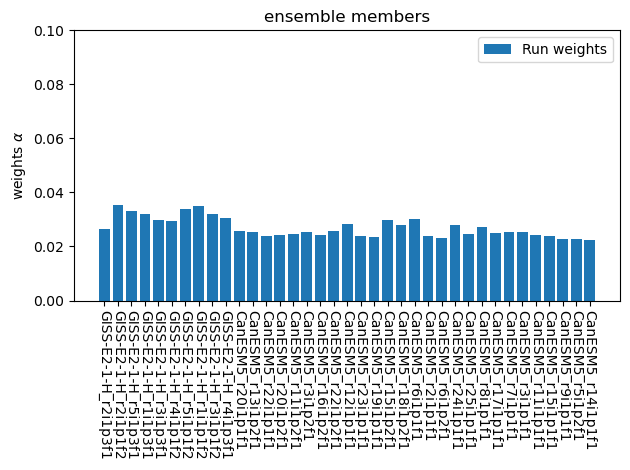

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


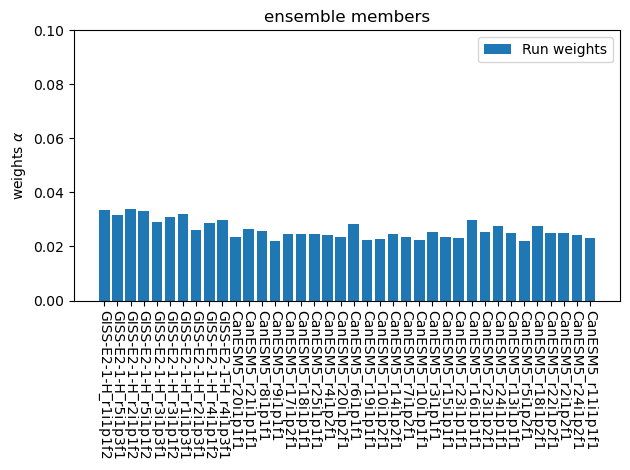

/tmp/ipykernel_37115/847346555.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(x.keys()), rotation=-90)


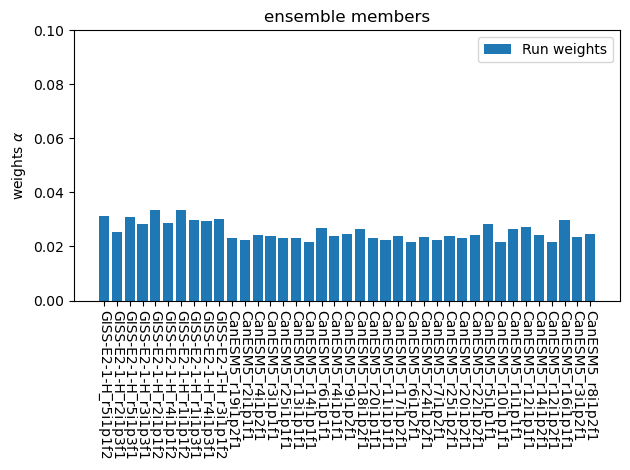

In [33]:
max_test = 30
# gamma = torch.zeros((max_test,30))
rmse = torch.zeros(max_test)

for idx,elt in enumerate(range(max_test)):
    
    n0_tmp = 10
    n1_tmp = elt
    
    # mix runs 
    x_tmp_mix,y_tmp_mix = mix_runs(swaped_models[0],swaped_models[1],n0_tmp,n1_tmp,x_train,y_train)
    
    runs = list(x_tmp_mix[swaped_models[0]+'_'+swaped_models[1]].keys())
        
    beta_swaped_tmp = train_robust_run(x_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],y_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],\
                                         runs,grid_lon_size,grid_lat_size,\
                                         alpha_=alpha_,lambda_=lambda_,\
                                         nbEpochs=200,verbose=False)
    
    
    gamma = plot_run_weights(beta_swaped_tmp,\
                            x_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],y_tmp_mix[swaped_models[0]+'_'+swaped_models[1]],\
                            alpha_=alpha_)
    ypred = np.matmul(beta_swaped_tmp,sst_tmp_zeros.T)

    rmse[idx] = torch.mean((ypred - ytrue)**2)

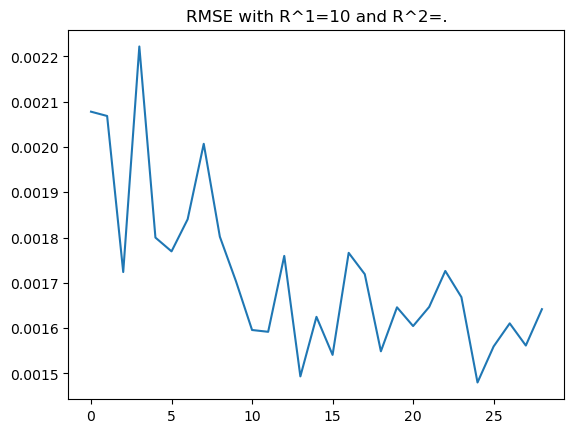

In [42]:
fig, ax = plt.subplots()

ax.plot(rmse[1:])
ax.set_title('RMSE with R^1=10 and R^2=.')
# ax.legend()
# ax.set_xticklabels(range(1,max_test))
# plt.tight_layout()
plt.savefig("rmse_"+str(n0_tmp)+".png")
import matplotlib.pyplot as plt

# compute negative part
beta[nans_idx] = float('nan')
beta_tmp = beta.numpy().reshape(grid_lat_size,grid_lon_size)

fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 1, 1)        
im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=0.00,vmax = 0.01)
plt.colorbar(im0, ax=ax0, shrink=0.3)
# ax0.set_xlabel(r'x', size=7)

plt.show()

In [40]:
rmse

tensor([0.0047, 0.0021, 0.0021, 0.0017, 0.0022, 0.0018, 0.0018, 0.0018, 0.0020,
        0.0018, 0.0017, 0.0016, 0.0016, 0.0018, 0.0015, 0.0016, 0.0015, 0.0018,
        0.0017, 0.0015, 0.0016, 0.0016, 0.0016, 0.0017, 0.0017, 0.0015, 0.0016,
        0.0016, 0.0016, 0.0016])

In [35]:
# fig, ax = plt.subplots()

# # x= list(dic_processed_ssp585.keys())
# # barcollection = plt.bar(x,list(np.ones(len(x))))
# ax.set_xticklabels(list(dic_processed_ssp585.keys()), rotation=-90)
# ax.set_ylim(0.0,1.0)

# def animate_weight(i):
#     ax.set_title(r'Model mean weights for $\alpha$ = '+ str(alpha_range[alpha_range.shape[0]-1-i])+ ', $\lambda$ = '+ str(lambda_grid.ravel()[8]) + ', RMSE: '+ str(a_map[i,8]))
#     for k, b in enumerate(barcollection):
#         b.set_height(list(weights_robust[(alpha_range[alpha_range.shape[0]-1-i],lambda_range[10])].values())[k])

# animation.FuncAnimation(fig, animate_weight, frames=alpha_range.shape[0])
# # ani_weight.save('robust_weights.mp4',writer=animation.FFMpegWriter(fps=10))

### Define a subset of models: like 2-3(4) models on which we do the swap, we train the models and test on a given set of models/real data.
### One swap: retrain everything and check the weights. Need to check pairs of similar models. (see if you get the same results)
### Learn run weights
### Add some smoothing in the pattern definition
### Think about a nonlinear approach like VAE to generate patterns given single observation.